In [1]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def lorentzian(X,x0,c):
    return c**2/(np.pi*c*(c**2+(X-x0)**2))

def ODMRfit(X,a1,f1,w1,a2,f2,w2):
    return a1*lorentzian(X,f1,w1)+a2*lorentzian(X,f2,w2)

def pol(X,phi,theta,a):
    return a*(np.cos(X-phi)**2+(np.cos(theta)*np.sin(X-phi))**2)

def OrientODMR(X,Y,Z):
    X = X[1:,:]
    Y = Y[1:,:]
    Z = Z[1:,:]
    
    poptX, pcovX = curve_fit(ODMRfit,X[:,0],X[:,1],p0=(-4E8,X[np.argmin(X[:,1]),0],1E7,-4E8,2.87E9*2-X[np.argmin(X[:,1]),0],1E7),
                           maxfev=2500)
    plt.plot(X[:,0],X[:,1],'ro')
    plt.plot(X[:,0],ODMRfit(X[:,0],*poptX),'r-')

    poptY, pcovY = curve_fit(ODMRfit,Y[:,0],Y[:,1],p0=(-4E8,Y[np.argmin(Y[:,1]),0],1E7,-4E8,2.87E9*2-Y[np.argmin(Y[:,1]),0],1E7),
                           maxfev=2500)
    plt.plot(Y[:,0],Y[:,1],'go')
    plt.plot(Y[:,0],ODMRfit(Y[:,0],*poptY),'g-')

    poptZ, pcovZ = curve_fit(ODMRfit,Z[:,0],Z[:,1],p0=(-4E8,Z[np.argmin(Z[:,1]),0],1E7,-4E8,2.87E9*2-Z[np.argmin(Z[:,1]),0],1E7),
                           maxfev=2500)
    plt.plot(Z[:,0],Z[:,1],'bo')
    plt.plot(Z[:,0],ODMRfit(Z[:,0],*poptZ),'b-')

    g = 28E6 #NV gyromagnetic ratio in Hz/mT
    Bx = np.abs(poptX[4]-poptX[1])/(2*g)
    By = np.abs(poptY[4]-poptY[1])/(2*g)
    Bz = np.abs(poptZ[4]-poptZ[1])/(2*g)
    
    Sx = 1/(2*g)*np.sqrt(np.diag(pcovX)[1]+np.diag(pcovX)[4])
    Sy = 1/(2*g)*np.sqrt(np.diag(pcovY)[1]+np.diag(pcovY)[4])
    Sz = 1/(2*g)*np.sqrt(np.diag(pcovZ)[1]+np.diag(pcovZ)[4])

    print "X field: %.2f +/- %.2f mT \nY field: %.2f +/- %.2f mT \nZ field: %.2f +/- %.2f mT" % (Bx,Sx,By,Sy,Bz,Sz)

    Bz = Bz/0.755 #scale Bz to account for inhomogenous field strength under z rotation
    B = np.sqrt(Bx**2+By**2+Bz**2)
    SB = np.sqrt((2*Bx/B)**2*Sx**2 + (2*By/B)**2*Sy**2 + (2*Bz/B)**2*Sz**2)
    phi = np.arctan(By/Bx)*180/np.pi
    Sphi = np.sqrt( (-1/((1+(By/Bx)**2)*Bx**2))**2*Sx**2 + (By**2/(1+(By/Bx)**2))**2*Sy**2 )
    theta = np.arccos(Bz/B)*180/np.pi
    print "B: %.2f +/- %.2f\nPhi: %.2f +/- %.2f\nTheta: %.2f or %.2f" % (B,SB,phi,Sphi,theta,180-theta)

def OrientPol(T,mirror=False):
    
    T[:,1] = T[:,1]+np.linspace(0,T[0,1]-T[-1,1],num=T.shape[0])
    
    if mirror:
        T_half = T[T[:,0]<180]
        T_half_copy = T[T[:,0]<180]
        T_half_copy[:,0] = T_half_copy[:,0]+180
        T = np.append(T_half,T_half_copy,axis=0)
    
    T[:,0] = T[:,0]*2*np.pi/360
   
    opt1,cov1 = curve_fit(pol,T[:,0],T[:,1],p0=(0,np.pi/4,np.max(T[:,1])))

    plt.polar(T[:,0],T[:,1],'ko')
    plt.polar(T[:,0],pol(T[:,0],*opt1),'r-')

    print "Phi: %2f +/- %2f" % (opt1[0]*180/np.pi,np.sqrt(np.diag(cov1))[0]*180/np.pi)
    print "Theta: %2f or +/- %2f" % (opt1[1]*180/np.pi,np.sqrt(np.diag(cov1))[1]*180/np.pi)
    print "Phi(naive): %2f" % (T[np.argmin(T[:,1]),0]*180/np.pi-90)
    print "Theta(naive): %2f" % (np.arccos(np.sqrt(np.min(T[:,1])/np.max(T[:,1])))*180/np.pi)

Phi: -54.541929 +/- 0.492215
Theta: 39.092494 or +/- 0.325294
Phi(naive): -65.455000
Theta(naive): 41.031250


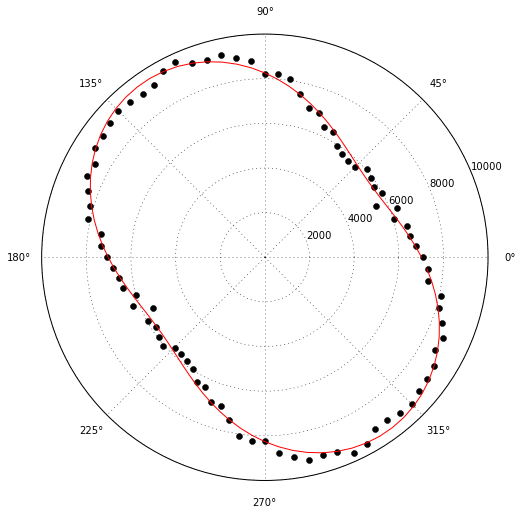

In [5]:
T1 = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 x112 y90 1mW rotor scan.txt')
T1[:,1] -= 2036
OrientPol(T1,True)

X field: 4.51 +/- 0.08 mT 
Y field: 9.57 +/- 0.04 mT 
Z field: 5.59 +/- 0.03 mT
B: 12.91 +/- 0.09
Phi: 64.74 +/- 0.66
Theta: 55.03 or 124.97


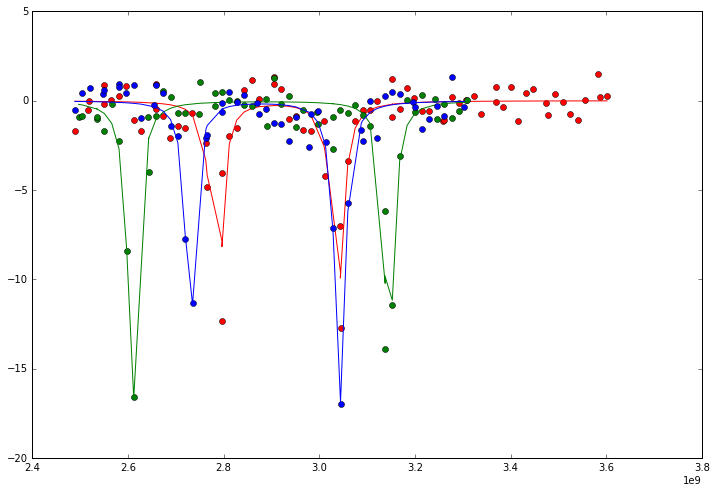

In [6]:
D1_X = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x112 y90 5mW B0.5V T0.txt')
D1_Y = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x112 y90 5mW B0.5V T90.txt')
D1_Z = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x112 y90 5mW B0.5V T0 X15_4.txt')
OrientODMR(D1_X,D1_Y,D1_Z)

Phi: -3.213277 +/- 0.182921
Theta: 52.785953 or +/- 0.173125
Phi(naive): -4.091000
Theta(naive): 53.755750


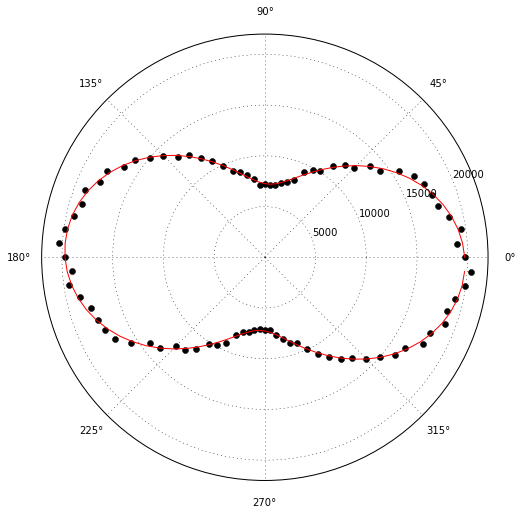

In [7]:
T2 = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 x12 y121 1mW rotor scan.txt')
T2[:,1] -= 2036
OrientPol(T2,True)

X field: 10.61 +/- 0.13 mT 
Y field: 2.71 +/- 0.07 mT 
Z field: 5.61 +/- 0.03 mT
B: 13.24 +/- 0.21
Phi: 14.31 +/- 0.46
Theta: 55.83 or 124.17


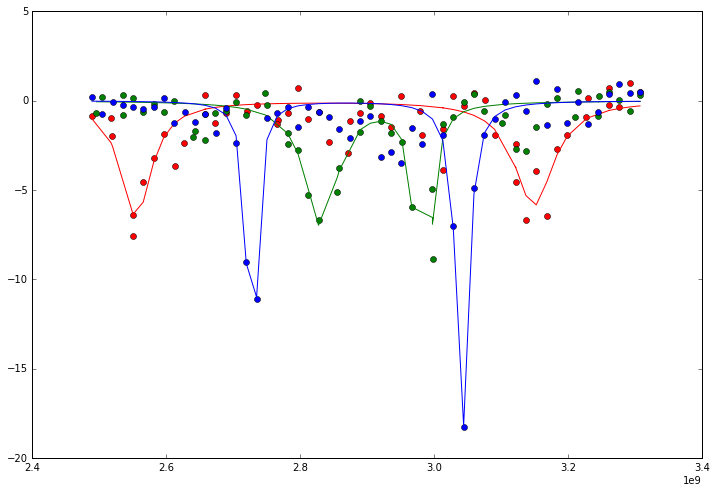

In [8]:
D2_X = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x12 y121 5mW B0.5V T0.txt')
D2_Y = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x12 y121 5mW B0.5V T90.txt')
D2_Z = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x12 y121 5mW B0.5V T0 X15_4.txt')
OrientODMR(D2_X,D2_Y,D2_Z)

Phi: -43.453156 +/- 0.426432
Theta: 45.156174 or +/- 0.329910
Phi(naive): -40.909000
Theta(naive): 46.661851


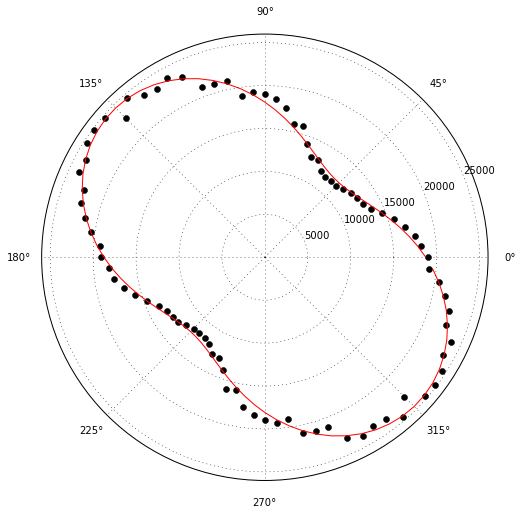

In [9]:
T3 = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 x74 y83 1mW rotor scan.txt')
T3[:,1] -= 2036
OrientPol(T3,True)

X field: 7.46 +/- 0.08 mT 
Y field: 8.70 +/- 0.03 mT 
Z field: 2.39 +/- 0.06 mT
B: 11.89 +/- 0.12
Phi: 49.38 +/- 0.84
Theta: 74.58 or 105.42


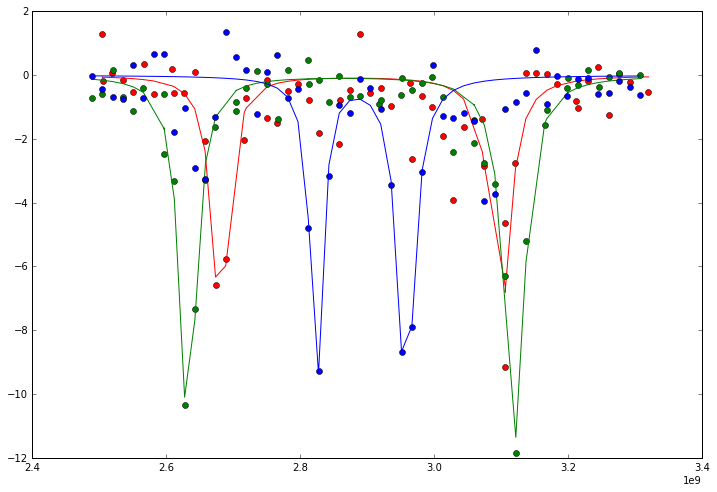

In [10]:
D3_X = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x74 y83 5mW B0.5V T0.txt')
D3_Y = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x74 y83 5mW B0.5V T90.txt')
D3_Z = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x74 y83 5mW B0.5V T0 X15_4.txt')
OrientODMR(D3_X,D3_Y,D3_Z)

Phi: 76.428488 +/- 0.550875
Theta: -50.135559 or +/- 0.485210
Phi(naive): 81.818000
Theta(naive): 52.155528


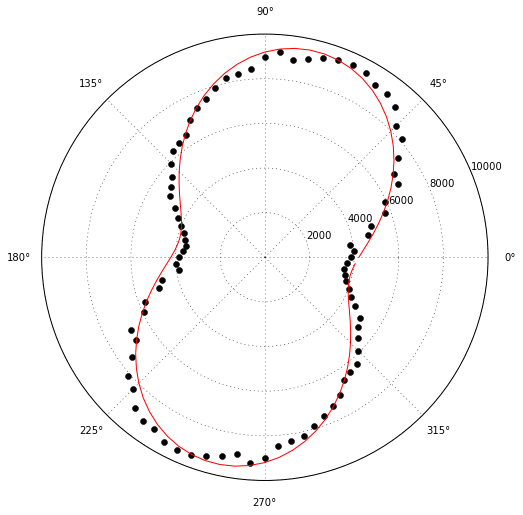

In [11]:
T4 = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 x36 y59 1mW rotor scan.txt')
T4[:,1] -= 2036
OrientPol(T4,True)

X field: 4.61 +/- 0.06 mT 
Y field: 7.91 +/- 0.03 mT 
Z field: 4.95 +/- 0.03 mT
B: 11.26 +/- 0.07
Phi: 59.77 +/- 0.43
Theta: 54.39 or 125.61


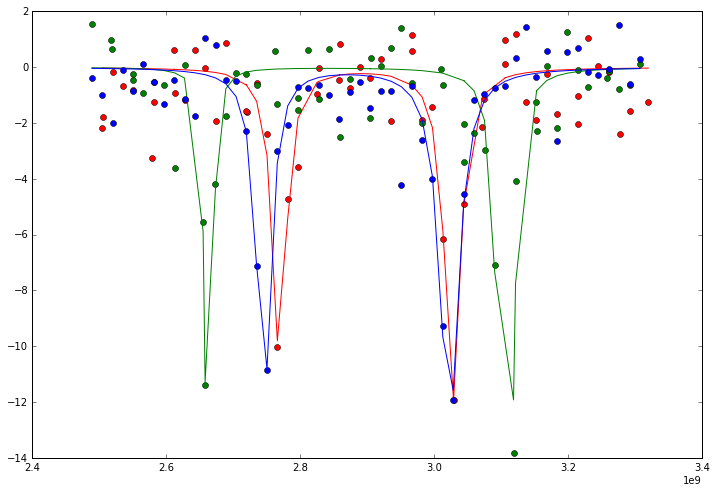

In [12]:
D4_X = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x36 y59 5mW B0.5V T0.txt')
D4_Y = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x36 y59 5mW B0.5V T90.txt')
D4_Z = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-27-16\Nabond on CPW scan 2 ODMR x36 y59 5mW B0.5V T0 X15_4.txt')
OrientODMR(D4_X,D4_Y,D4_Z)

In [2]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh import palettes
output_notebook()
TOOLS = "box_zoom,box_select,crosshair,hover,resize,reset,save"

Loading BokehJS ...

In [5]:
files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\5-28-16\Nabond on CPW 5mW scan 2 Dot 1 x82 y85 T65 d5_1 *V.txt')
output_file("5-28-16 Dot 1 ODMR.html")
bsweep = pd.concat((pd.read_table(f) for f in files),axis=1).values
diffs = bsweep[:,1::2]
diffs = np.nan_to_num(diffs)
Bs = np.linspace(0,0.947,len(files))*(11/0.5)
p1 = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[1,0],bsweep[-2,0]],tools=TOOLS)
p1.image(image=[diffs],x=Bs[0], y=bsweep[1,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[1,0]], palette='RdPu9')
p1.line(Bs,2.864E9+28E6*Bs,line_dash=(6,6),line_color='black')
p1.line(Bs,2.864E9-28E6*Bs,line_dash=(6,6),line_color='black')
p1.xaxis.axis_label = "B_ext (mT)"
p1.yaxis.axis_label = "Freq"
show(p1)


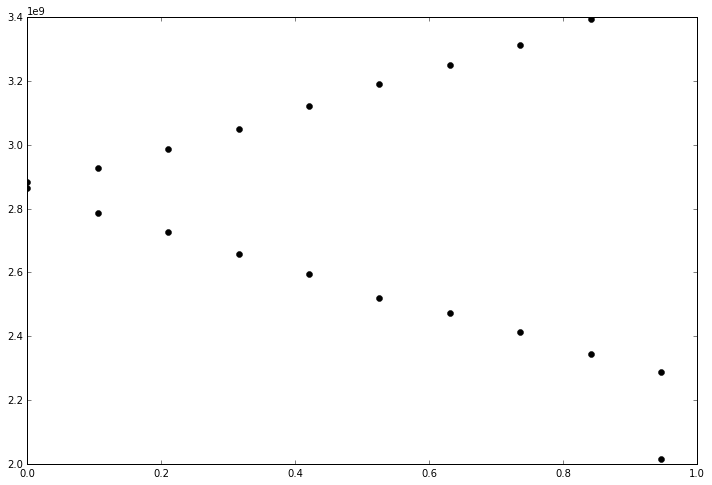

In [15]:
freq = bsweep[:,2]
fits = np.zeros((diffs.shape[1],6))
for i in range(0,diffs.shape[1]):
    O = diffs[:,i]
    opt, cov = curve_fit(ODMRfit,freq,O,p0=(-4E8,freq[np.argmin(O)],1E7,-4E8,2.87E9*2-freq[np.argmin(O)],1E7),maxfev=2500)
    fits[i,:] = opt
    
mask = (fits[:,1]<fits[:,4])
mins = fits[:,1]*mask + fits[:,4]*~mask
maxs = fits[:,1]*~mask + fits[:,4]*mask
plt.plot(Bs*0.5/11,mins,'ko')
plt.plot(Bs*0.5/11,maxs,'ko')

In [16]:
def ODMR_theory_min(B,theta):
    D = 2.86E9
    g = 28E6 #MHz/mT, B should be in mT
    
    f_0 = D + 3*g**2*B**2/(2*D)*np.sin(theta)**2
    f_1 = g*B*np.cos(theta)*np.sqrt( 1 + (g*B/(2*D)*np.tan(theta)*np.sin(theta))**2)
    
    return f_0-f_1

def ODMR_theory_max(B,theta):
    D = 2.86E9
    g = 28E6 #MHz/mT, B should be in mT
    
    f_0 = D + 3*g**2*B**2/(2*D)*np.sin(theta)**2
    f_1 = g*B*np.cos(theta)*np.sqrt( 1 + (g*B/(2*D)*np.tan(theta)*np.sin(theta))**2)
    
    return f_0+f_1

In [17]:
opt, cov = curve_fit(ODMR_theory_min,Bs[0:-1],mins[0:-1],p0=(np.pi/4))
print "%2f +/- %2f" % (opt*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)
opt, cov = curve_fit(ODMR_theory_max,Bs[0:-1],maxs[0:-1],p0=(0.6))
print "%2f +/- %2f" % (opt*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)

0.002671 +/- inf
-0.002237 +/- inf


C:\Users\Ouyang Group\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [3]:
files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\5-30-16\Nabond ND on CPW 5mW scan 1 x102 y72 T-65 d5_1 *V.txt')
output_file("5-30-16 Dot 1 ODMR cropped.html")
bsweep = pd.concat((pd.read_table(f) for f in files),axis=1).values
diffs = bsweep[:,1::2]
diffs = np.nan_to_num(diffs)
Bs = np.linspace(0,3,len(files))*(11/0.5)
p1 = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[1,0],bsweep[-2,0]],tools=TOOLS)
p1.image(image=[diffs],x=Bs[0], y=bsweep[1,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[1,0]], palette='RdPu9')
p1.line(Bs,2.864E9+28E6*Bs,line_dash=(6,6),line_color='black')
p1.line(Bs,2.864E9-28E6*Bs,line_dash=(6,6),line_color='black')
p1.xaxis.axis_label = "B_ext (mT)"
p1.yaxis.axis_label = "Freq"
show(p1)


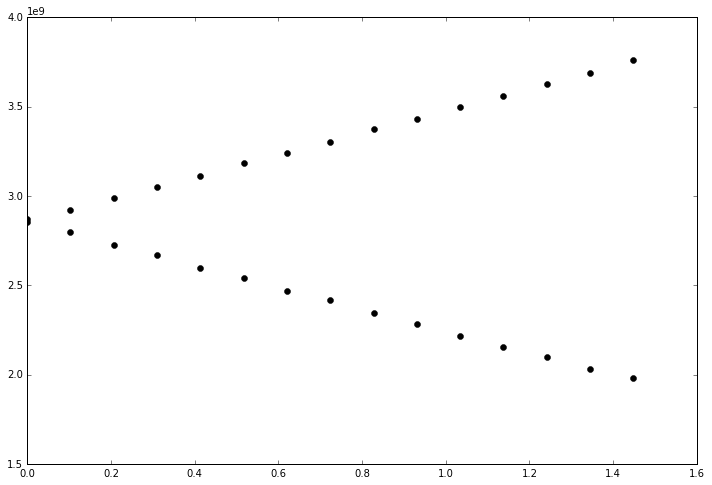

In [17]:
freq = bsweep[:,2]
fits = np.zeros((diffs.shape[1],6))
for i in range(0,diffs.shape[1]):
    O = diffs[:,i]
    opt, cov = curve_fit(ODMRfit,freq,O,p0=(-4E8,freq[np.argmin(O)],1E7,-4E8,2.87E9*2-freq[np.argmin(O)],1E7),maxfev=2500)
    fits[i,:] = opt
    
mask = (fits[:,1]<fits[:,4])
mins = fits[:,1]*mask + fits[:,4]*~mask
maxs = fits[:,1]*~mask + fits[:,4]*mask
plt.plot(Bs[0:15]*0.5/11,mins[0:15],'ko')
plt.plot(Bs[0:15]*0.5/11,maxs[0:15],'ko')

In [22]:
p1 = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[1,0],bsweep[-2,0]],tools=TOOLS)
p1.image(image=[diffs],x=Bs[0], y=bsweep[1,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[1,0]], palette='RdPu9')
p1.circle(Bs[0:15],mins[0:15],color='black')
p1.circle(Bs[0:15],maxs[0:15],color='black')
show(p1)

In [28]:
res = np.stack([Bs*(0.5/11),mins,maxs],axis=1)
np.savetxt('5-30-16 Dot 1 ODMR fits.txt',res,delimiter='\t',newline='\n')

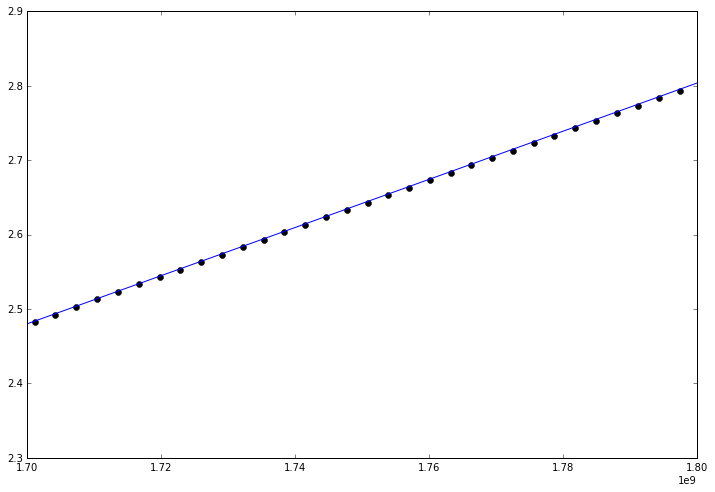

In [171]:
fv = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\volt-freq relation 6-2-16.txt')
#plt.ylim([2.5E9,2.6E9])
#plt.xlim([5,5.9])
fv = fv[fv[:,1]>1E8]
plt.xlim((1.7E9,1.8E9))
plt.ylim((2.3,2.9))
plt.plot(fv[:,1],fv[:,0],'ko')
plt.plot(fv[:,1],fv[:,1]*slope+intercept,'b-')

In [167]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(fv[:,1],fv[:,0])

In [168]:
print slope, intercept
print slope*1.78735E9+intercept

3.23484510571e-09 -3.01913553387
2.76266486582


In [12]:
#import pdb
output_file("Dot 1 Rabi.html")
files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\5-30-16\Nabond ND on CPW 5mW scan 1 x104 y67 T-65 d5_1 B0.5V 6 Rabi *[0-9]')
pseq = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\5-30-16\Nabond ND on CPW 5mW scan 1 x104 y67 T-65 d5_1 B0.5V 6 Rabi Pulse Seq')
d_sum = np.zeros((pseq.shape[0],))
l = pseq.shape[0]
for f in files:
    epr = np.loadtxt(f)
    #pdb.set_trace()
    diff = np.divide((epr[:,0]-epr[:,1]),epr[:,1])
    diff = np.nan_to_num(diff)
    diff.resize(((diff.shape[0] - (diff.shape[0] % l)),1))
    diff = np.reshape(diff,(pseq.shape[0],-1),order='F')
    d_sum += np.mean(diff,axis=1)

p=figure(tools=TOOLS)
p.line(pseq,d_sum)
show(p)

In [4]:
def EPR(EPRfiles,Pfiles):
    files = glob.glob(EPRfiles)
    pseq = np.loadtxt(Pfiles)
    d_sum = np.zeros((pseq.shape[0],))
    l = pseq.shape[0]
    for f in files:
        epr = np.loadtxt(f)
        diff = np.divide((epr[:,0]-epr[:,1]),epr[:,1])
        diff = np.nan_to_num(diff)
        diff.resize(((diff.shape[0] - (diff.shape[0] % l)),1))
        diff = np.reshape(diff,(pseq.shape[0],-1),order='F')
        d_sum += np.mean(diff,axis=1)
        
    return pseq,d_sum/len(files)


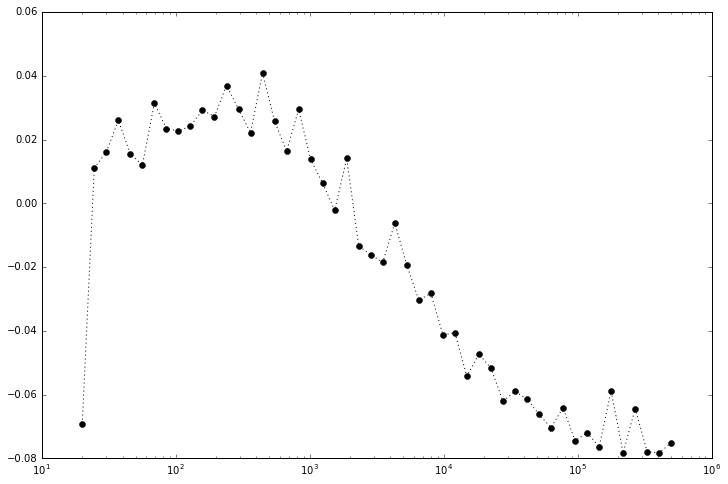

In [7]:
time,T1 = EPR(r'C:\Users\Ouyang Group\Documents\Data\8-24-15\#6 10nm ND after baking 25mw scan 3 x142 y136 T1 7200 sec *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\8-24-15\#6 10nm ND after baking 25mw scan 3 x142 y136 T1 7200 sec  Pulse Seq')
plt.semilogx(time,T1,'ko:')

In [33]:
T1

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan])

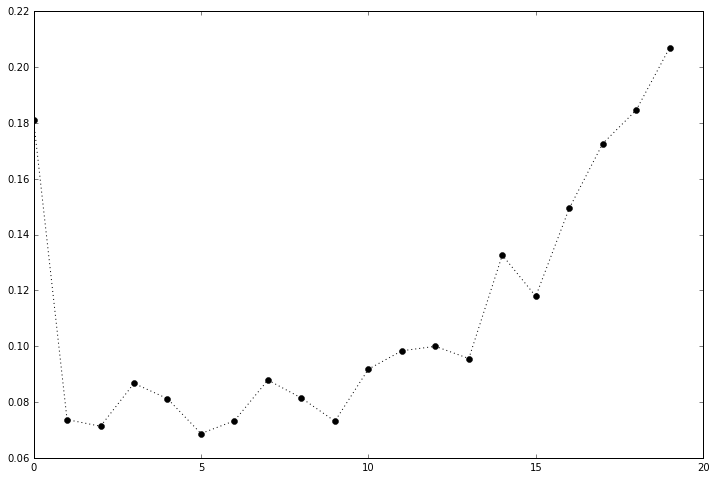

In [13]:
time,rabi0 = EPR(r'C:\Users\Ouyang Group\Documents\Data\5-31-16\Nabond ND on CPW 5mW scan 1 x102 y72 T-65 d5_1 T1 0V *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\5-31-16\Nabond ND on CPW 5mW scan 1 x102 y72 T-65 d5_1 T1 0V Pulse Seq')
plt.plot(rabi0,'ko:')

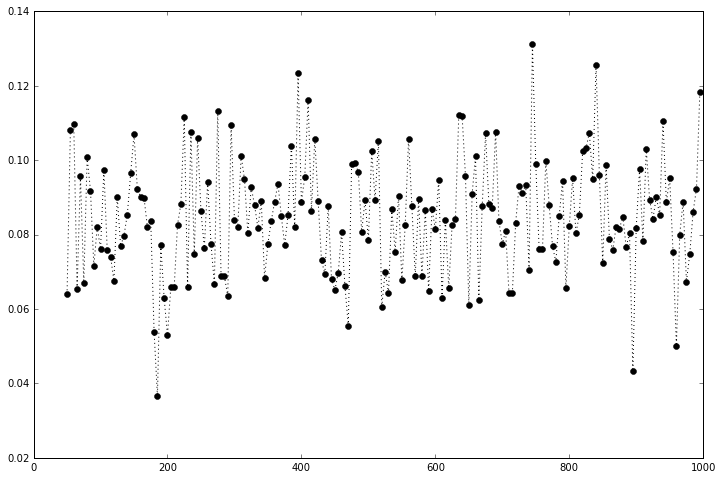

In [127]:
time,rabi1 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x78 y111 1500 sec 0.103000 V  *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x78 y111 1500 sec 0.103000 V   Pulse Seq')
plt.plot(time,rabi1,'ko:')

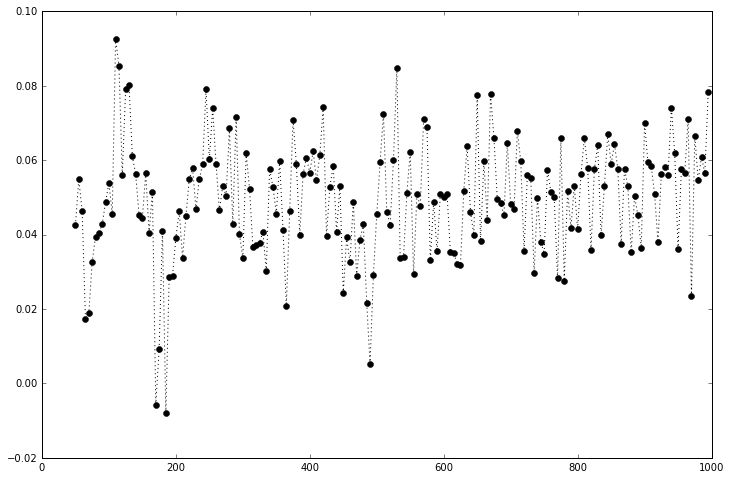

In [128]:
time,rabi2 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x78 y110 1500 sec 0.207000 V *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x78 y110 1500 sec 0.207000 V   Pulse Seq')
plt.plot(time,rabi2,'ko:')

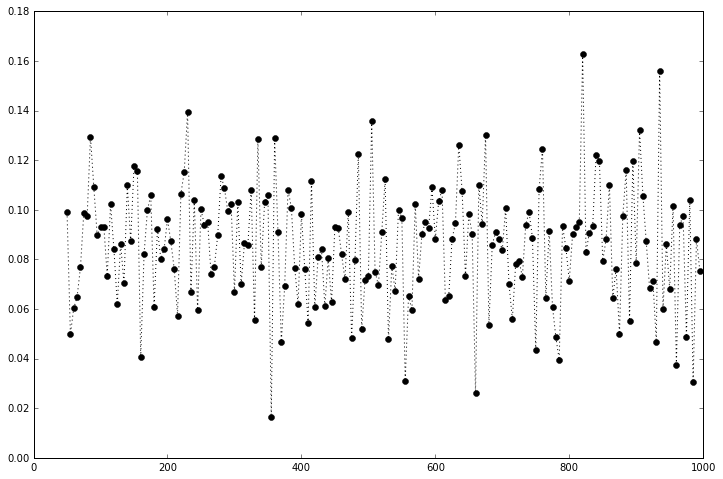

In [129]:
time,rabi3 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x78 y110 1500 sec 0.310000 V *[0-2]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x78 y110 1500 sec 0.310000 V   Pulse Seq')
plt.plot(time,rabi3,'ko:')

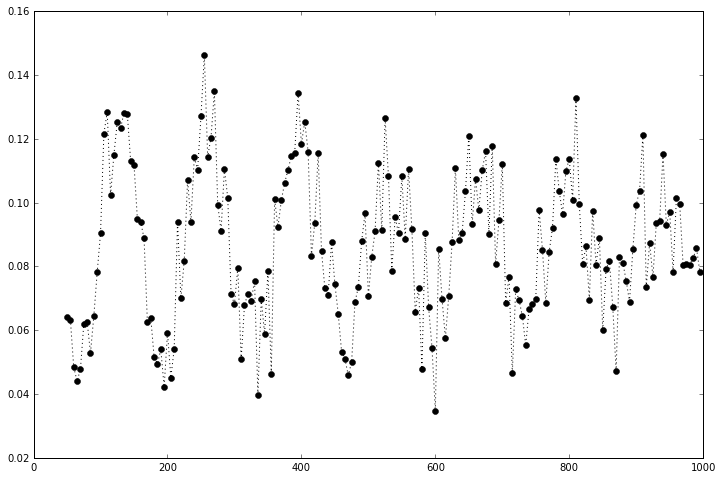

In [130]:
time,rabi4 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x82 y105 1500 sec 0.414000 V *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x82 y105 1500 sec 0.414000 V   Pulse Seq')
plt.plot(time,rabi4,'ko:')

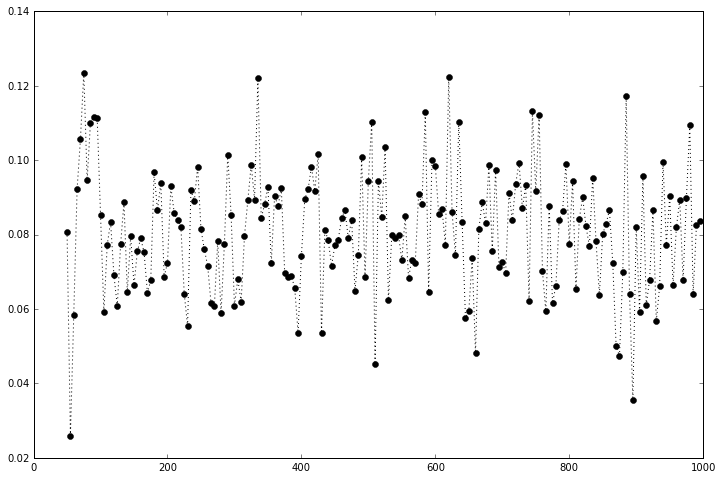

In [131]:
time,rabi5 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x85 y101 1500 sec 0.517000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x85 y101 1500 sec 0.517000 V   Pulse Seq')
plt.plot(time,rabi5,'ko:')

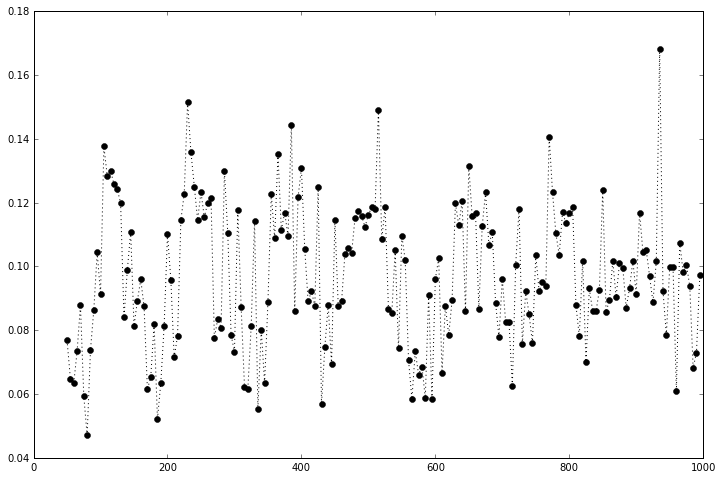

In [132]:
time,rabi6 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x87 y98 1500 sec 0.621000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x87 y98 1500 sec 0.621000 V   Pulse Seq')
plt.plot(time,rabi6,'ko:')

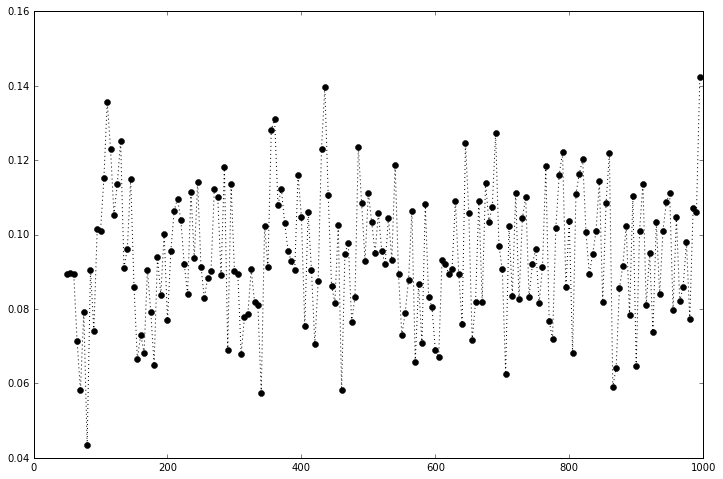

In [133]:
time,rabi7 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x89 y97 1500 sec 0.724000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x89 y97 1500 sec 0.724000 V   Pulse Seq')
plt.plot(time,rabi7,'ko:')

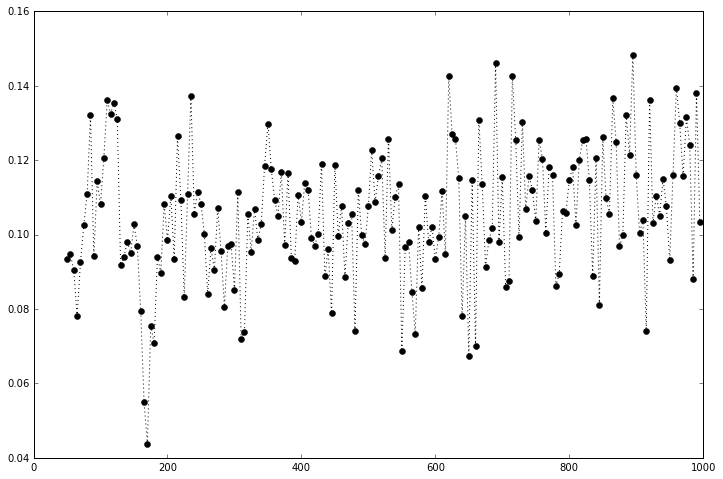

In [134]:
time,rabi8 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x90 y97 1500 sec 0.828000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x90 y97 1500 sec 0.828000 V   Pulse Seq')
plt.plot(time,rabi8,'ko:')

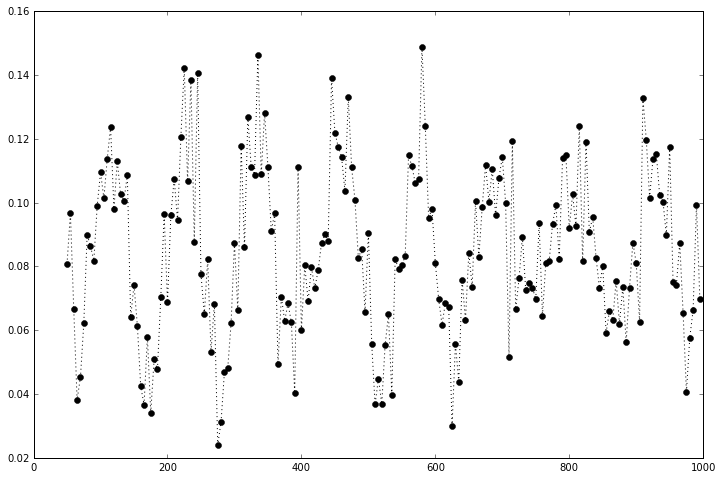

In [135]:
time,rabi9 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x92 y94 1500 sec 0.931000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x92 y94 1500 sec 0.931000 V   Pulse Seq')
plt.plot(time,rabi9,'ko:')

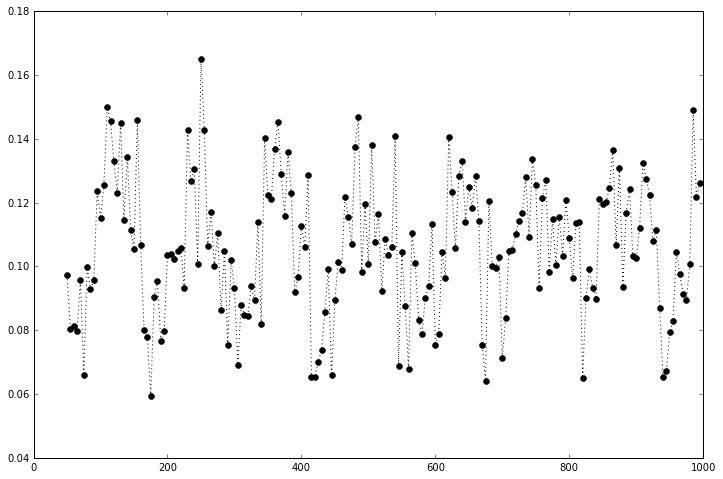

In [136]:
time,rabi10 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x93 y92 1500 sec 1.034000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x93 y92 1500 sec 1.034000 V   Pulse Seq')
plt.plot(time,rabi10,'ko:')

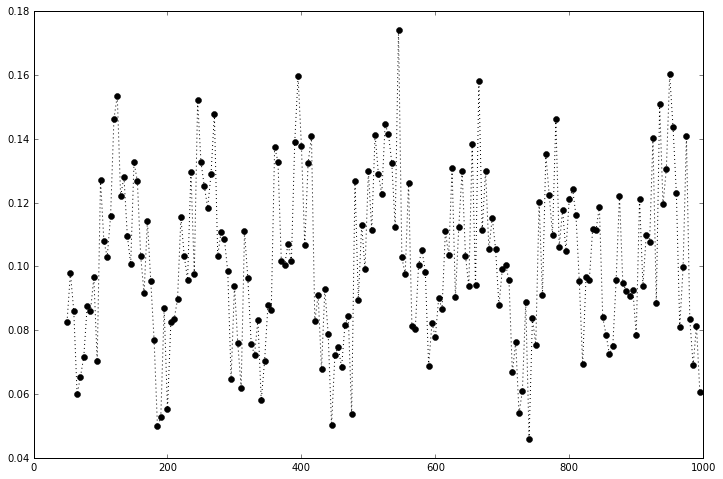

In [137]:
time,rabi11 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x94 y92 1500 sec 1.138000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x94 y92 1500 sec 1.138000 V   Pulse Seq')
plt.plot(time,rabi11,'ko:')

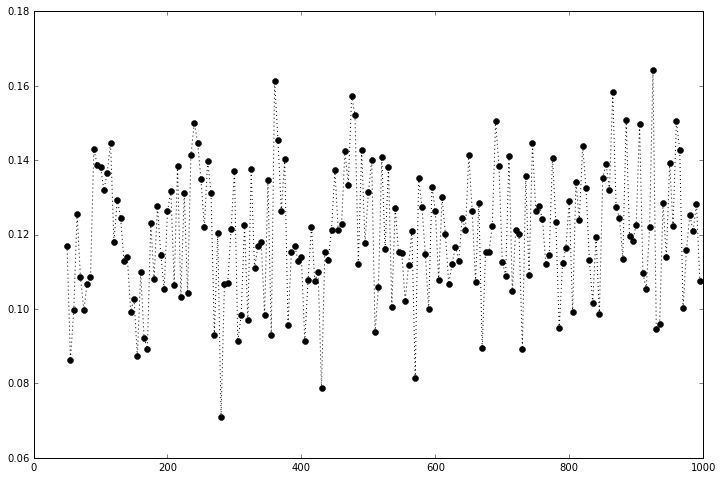

In [138]:
time,rabi12 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x95 y91 1500 sec 1.241000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x95 y91 1500 sec 1.241000 V   Pulse Seq')
plt.plot(time,rabi12,'ko:')

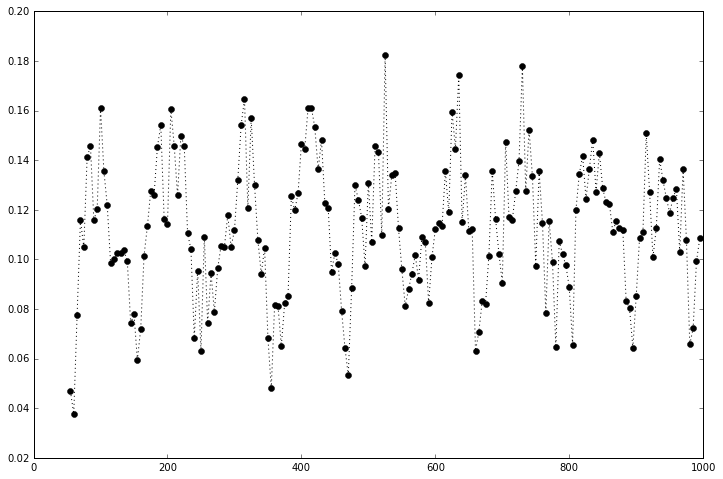

In [140]:
time,rabi13 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x95 y90 1500 sec 1.345000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x95 y90 1500 sec 1.345000 V   Pulse Seq')
plt.plot(time[1:],rabi13[1:],'ko:')

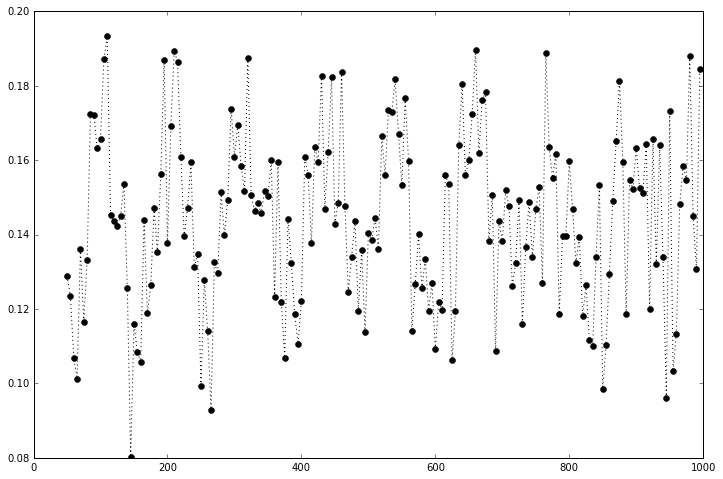

In [141]:
time,rabi14 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x97 y90 1500 sec 1.448000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x97 y90 1500 sec 1.448000 V   Pulse Seq')
plt.plot(time,rabi14,'ko:')

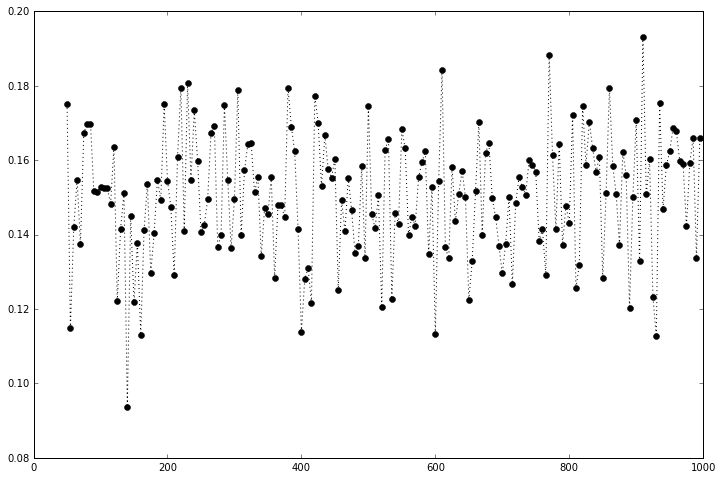

In [142]:
time,rabi15 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x97 y89 1500 sec 1.552000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x97 y89 1500 sec 1.552000 V   Pulse Seq')
plt.plot(time,rabi15,'ko:')

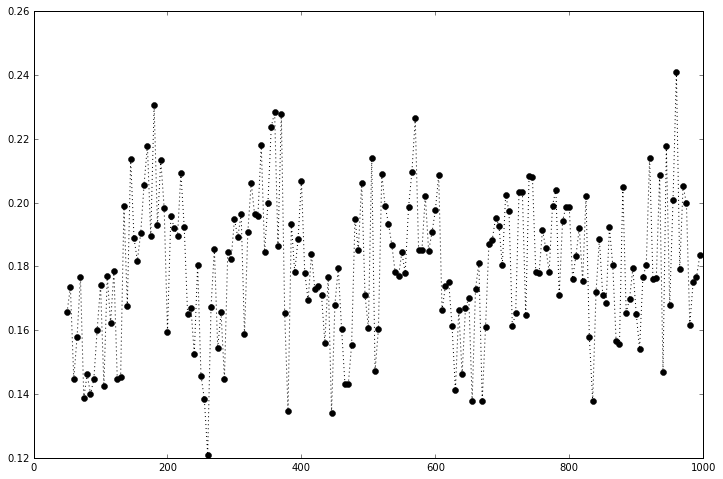

In [143]:
time,rabi16 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x97 y90 1500 sec 1.655000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x97 y90 1500 sec 1.655000 V   Pulse Seq')
plt.plot(time,rabi16,'ko:')

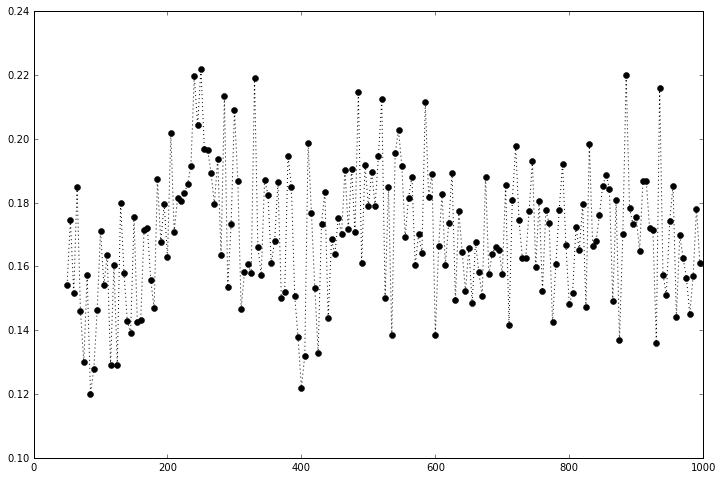

In [144]:
time,rabi17 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x99 y90 1500 sec 1.759000 V *[4-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-1-16\Dot 1 5mW Rabi updated  x99 y90 1500 sec 1.759000 V   Pulse Seq')
plt.plot(time,rabi17,'ko:')

In [2]:
files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\6-2-16\Dot 1 5mW local ODMR upper *V ODMR')
for f in files:
    o = np.loadtxt(f)
    

38.0